In [2]:
import dataset_functions
from importlib import reload
reload(dataset_functions)
from dataset_functions import *

from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch
from matplotlib import cm
from scipy.stats import pearsonr, gaussian_kde, beta
from tabulate import tabulate

os.makedirs('plots/WOC', exist_ok=True)
os.makedirs('plots/theory', exist_ok=True)

Loaded precomputed task_params_df from disk.
Loaded precomputed task_params_df from disk.


# WoC

## Scores vs c

c:\Users\marin\Documents\SDU\WoC_revisited\src\dataset_functions.py:727: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  ax.grid(grid_option, axis=grid_option if grid_option else 'both', alpha=alpha_grid)


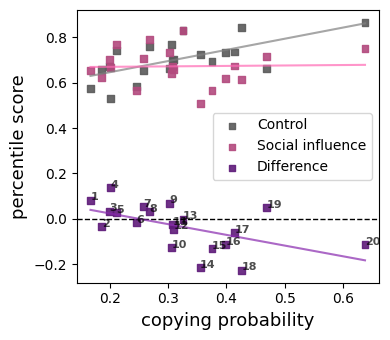

Pearson correlation: -0.549, p-value: 0.0122


In [3]:
f, ax = plt.subplots(1, 1, figsize=(4, 3.5))
base=dict(
    acc=(0, 1),
    mae=True,
    weighted=0,
    equaldots=True,
    fit_on="means",
    show_fit=True,
    show_tasks=False,
    fit_label=False,
    ylabel_fontsize=13,
    xlabel_fontsize=13,
    label_alpha=0.7,
    label_fontsize=8,
    grid_option=False,
    alpha_grid=0,
    ylabel='percentile score',
    return_data=True,
)
a = all_tasks_regression_two_conditions(
    base=base, title=None, ax=ax, 
    )

plt.tight_layout()
plt.savefig('plots/WOC/WOC_error_per_c.png', dpi=300)
plt.show()
plt.close()

# Compute Pearson correlation between the differences and the c values
diffs = a["difference"]["Y_means"]
cs = sorted(list(c_per_domain.values()))
assert len(diffs) == len(cs), "Arrays must be of the same length for correlation. Now diffs has length {} and cs has length {}.".format(len(diffs), len(cs))
correlation, p_value = pearsonr(diffs, cs)
print(f"Pearson correlation: {correlation:.3f}, p-value: {p_value:.4f}")

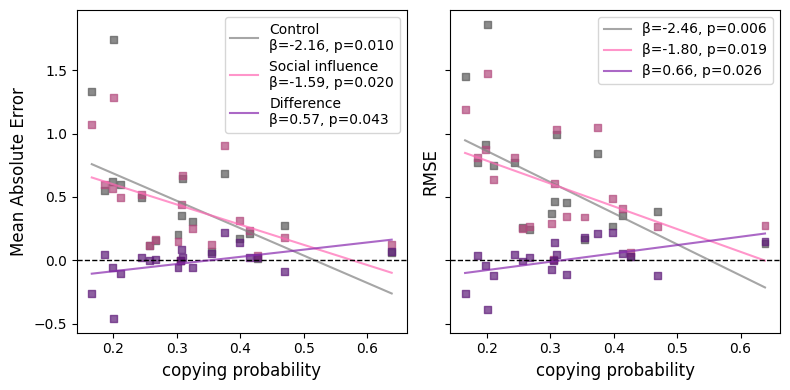

In [4]:
foo = lambda d: np.array(d['absolute_error'])/d['std_dev']
f, ax = plt.subplots(1, 2, figsize=(8, 4), sharey=True, sharex=True)
base=dict(
    acc=(0, 1),
    mae=True,
    weighted=0,
    equaldots=True,
    fit_on="means",
    show_fit=True,
    show_tasks=False,
    fit_label=True,
    ylabel_fontsize=12,
    xlabel_fontsize=12,
    label_alpha=0.7,
    label_fontsize=8,
    grid_option=False,
    alpha_grid=0,
    ylabel='Mean Absolute Error',
    alpha_mean=0.7,
    annotate_domain_means=False,
    title=None,
    joint_labels=True,
    return_data=True,
)

ret1 = all_tasks_regression_two_conditions(
    func_y=foo,
    base=base, title=" ", ax=ax[0])
ret2 = all_tasks_regression_two_conditions(
    func_y=foo,
    base={**base, 'mae': False, 'ylabel': 'RMSE', 'joint_labels': False, 'label':None}, ax=ax[1])

plt.tight_layout()
plt.savefig('plots/WOC/error_metrics_vs_mu_c.png', dpi=300)
plt.show()
plt.close()

## Last median update

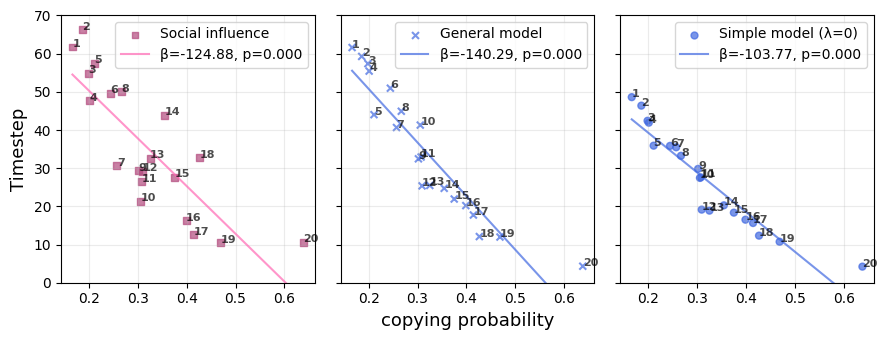

R^2 of general model: 0.678
R^2 of simple model: 0.450


In [5]:
f, ax = plt.subplots(1, 3, figsize=(9,3.5), sharey=True, sharex=True)
base=dict(
    title=None,
    show_tasks=0,
    fit_label=1,
    label_fontsize=8,
    s_mean=25,
    fit_on='means',
    alpha_mean=0.7,
    xlabel_fontsize=13,
    ylabel_fontsize=13,
    )

res0 = all_tasks_regression(**base, 
                   func_y=lambda d: d['last_median_update'][1],
                   ylabel='Timestep', xlabel=None,
                   ax=ax[0], color=palette['Consensus'], label="Social influence",
                   return_data=True)

res1 = all_tasks_regression(**base,
                   func_y=lambda d: d['last_update_sims_domain'],
                    ylabel=None,
                    label="General model",
                    ax=ax[1],
                    marker_mean='x',
                    color='royalblue',
                    color_mean="royalblue",
                    return_data=True
)

res2 = all_tasks_regression(**base,
    func_y=lambda d: d['last_update_sims_lambda_zero'],
    ylabel=None, xlabel=None,
    label='Simple model (λ=0)',
    ax=ax[2],
    marker_mean='o',
    color='royalblue',
    color_mean="royalblue",
    return_data=True
)

ax[0].set_ylim(bottom=0)
plt.tight_layout()
plt.savefig('plots/WOC/convergenceTime.png', dpi=300)
plt.show()
plt.close()

# print(res1["fitting"], res2["fitting"])
def r2_model_to_real(Y1, Y2):
    """
    R^2_model→real = 1 - sum (Y1 - Y2)^2 / sum (Y1 - mean(Y1))^2
    """
    y = np.asarray(Y1, dtype=float)
    yhat = np.asarray(Y2, dtype=float)

    # drop NaNs pairwise if needed
    mask = np.isfinite(y) & np.isfinite(yhat)
    y = y[mask]
    yhat = yhat[mask]

    sse = np.sum((y - yhat) ** 2)
    sst = np.sum((y - np.mean(y)) ** 2)

    # handle constant Y1 (sst=0)
    if sst == 0:
        return np.nan  # or 0.0 if you prefer

    return 1.0 - sse / sst

R2_full = r2_model_to_real(res0["Y_means"], res1["Y_means"])
R2_simple = r2_model_to_real(res0["Y_means"], res2["Y_means"])
print(f"R^2 of general model: {R2_full:.3f}")
print(f"R^2 of simple model: {R2_simple:.3f}")

## Accurate starts

In [6]:
def start_cuttoff(w=0, *, ps = [0.1, 0.25, 0.5], common_kwargs=None, ax=None, label=None):
    """
    common_kwargs: dict of keyword args passed into all_tasks_regression for every subplot.
                  Per-subplot overrides (acc, ax, title, etc.) will still be applied.
    """
    if common_kwargs is None:
        common_kwargs = {}

    if ax is None:
        f, ax = plt.subplots(len(ps), 3, figsize=(15, 4*len(ps)), sharey=True, sharex=True)
    
    ax = ax.reshape(len(ps), 3)

    ax[0][0].set_ylim(0, 1.1)

    # defaults shared across all calls (you can override any via common_kwargs)
    base = dict(
        mae=1,
        ylabel=None,
        xlabel=None,
        alpha_task=0.4,
        alpha_mean=0.8,
        show_tasks=True,
        show_means=True,
        annotate_domain_means=True,
        equaldots=1,
        s_task=8,
        s_mean=20,
        label_fontsize=8,
        fit_on="all",
        show_fit=True,
        weighted=bool(w),
        grid_option='y',
        alpha_grid=0.2,
    )
    base.update(common_kwargs)

    for i, p in enumerate(ps):
        panels = [
            ((0, p),     ax[i][0], f"({0:.2f}, {p:.2f}]"),
            ((p, 1 - p), ax[i][1], f"({p:.2f}, {1-p:.2f}]"),
            ((1 - p, 1), ax[i][2], f"({1-p:.2f}, {1:.2f}]"),
        ]

        for acc_rng, ax_ij, ttl in panels:
            all_tasks_regression(
                **base,
                acc=acc_rng,
                ax=ax_ij,
                title=ttl,
                label=label if i == 0 and ax_ij == ax[0][0] else None,
            )

        if i != len(ps) - 1:
            for j in range(3):
                ax[i][j].set_xlabel("")

        for j in range(1,3):
            ax[i][j].set_ylabel("")

    plt.tight_layout()
    # plt.show()



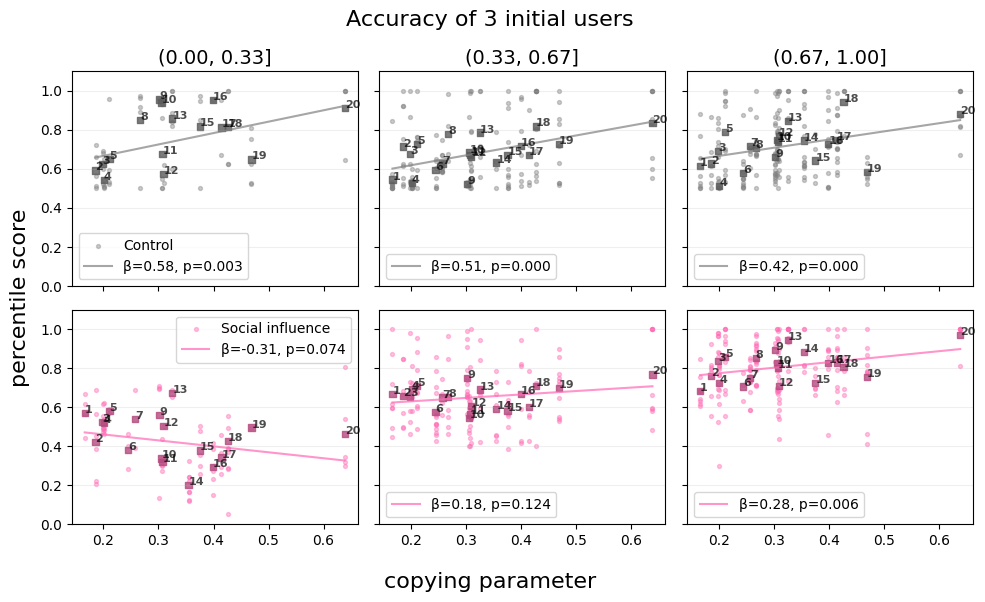

Tasks per bin in the control
[0, 0.33]: 61
(0.33, 0.67]: 155
(0.67, 1]: 183 

Tasks per bin in the social influence condition
[0, 0.33]: 77
(0.33, 0.67]: 150
(0.67, 1]: 172


In [7]:
f, ax = plt.subplots(2, 3, figsize=(10, 6), sharey=True, sharex=True)
start_cuttoff(w=0, ps=[1/3], 
              common_kwargs={'func_y': lambda d: d['scores'][0], 'color': palette["Control"], 'condition': 0}, 
              ax=ax[0], label="Control")
start_cuttoff(w=0, ps=[1/3], 
              common_kwargs={'func_y': lambda d: d['scores'][1], 'color': palette['Consensus'], 'condition': 1}, 
              ax=ax[1], label="Social influence")

for axis in ax[1]:
    axis.set_title(None)

# set common y-label
f.supylabel('percentile score', fontsize=16)
f.supxlabel('copying parameter', fontsize=16)

plt.suptitle("Accuracy of 3 initial users", y=0.98, fontsize=16)
plt.tight_layout()
plt.savefig('plots/WOC/initial_accuracy_0.33.png', dpi=300)
plt.show()

# tasks in each bin
print(f"Tasks per bin in the control")
print("[0, 0.33]:", sum(1 for t in task_params_dict if task_params_dict[t]['starting_accuracy'][0] <= 1/3))
print("(0.33, 0.67]:", sum(1 for t in task_params_dict if 1/3 < task_params_dict[t]['starting_accuracy'][0] <= 2/3))
print("(0.67, 1]:", sum(1 for t in task_params_dict if task_params_dict[t]['starting_accuracy'][0] > 2/3), "\n")

print(f"Tasks per bin in the social influence condition")
print("[0, 0.33]:", sum(1 for t in task_params_dict if task_params_dict[t]['starting_accuracy'][1] <= 1/3))
print("(0.33, 0.67]:", sum(1 for t in task_params_dict if 1/3 < task_params_dict[t]['starting_accuracy'][1] <= 2/3))
print("(0.67, 1]:", sum(1 for t in task_params_dict if task_params_dict[t]['starting_accuracy'][1] > 2/3))

In [8]:
def initial_final_accuracy_scatter_plot(condition, ax=None, bounds=[0, 1/3, 2/3, 1], size=30, alpha=0.5,
                                        colormap_name='Spectral', plot_colormap=True, cax=None):
    """
    Scatter plot of initial vs final accuracy for all tasks.
    Color-coded by task c parameter.
    0: Control, 1: Consensus, 2: Most recent, 3: Most confident
    """
    if ax is None:
        f, ax = plt.subplots(figsize=(5, 5))
        cax = ax

    # colormap
    cmap_ = ListedColormap(["#245799", "#a887ef", '#d73027'])

    # set boundaries for colormap
    norm = BoundaryNorm(bounds, cmap_.N)

    data = {}
    for task_id, params in task_params_dict.items():
        data[task_id] = {
            "initial_accuracy": params["starting_accuracy"][condition],
            "final_accuracy": params["scores"][condition],
            "c": params["c"]
        }


    ax.scatter([d["initial_accuracy"] for d in data.values()], 
               [d["final_accuracy"] for d in data.values()],
            #    c="gray", # placeholder, will be overridden by cmap
            #    c=[norm(d["c"]) for d in data.values()],
               facecolors="gray",
               edgecolors=[cmap_(norm(d["c"])) for d in data.values()],
            #    edgecolors='w',
               cmap=cmap_,
               alpha=alpha,
               linewidths=1,
               s=size
               )

    # fit in c bins [0, 0.33], [0.33, 0.67], [0.67, 1.0]
    for (a,b) in [[bounds[i], bounds[i+1]] for i in range(len(bounds)-1)]:
        bin_data = [d for d in data.values() if a < d["c"] <= b]
        print(len(bin_data), f"tasks with c in ({a}, {b}]")
        if len(bin_data) < 2:
            continue
        slope, intercept, r_value, p_value, std_err = linregress([d["initial_accuracy"] for d in bin_data], [d["final_accuracy"] for d in bin_data])
        x_vals = np.array([0, 1.05])
        ax.plot(x_vals, slope*x_vals + intercept, color=cmap_(norm((a+b)/2)),
                label=f'β={slope:.2f}, p={p_value:.3f}', linewidth=2)

    
    # plot colormap
    if plot_colormap:
        sm = plt.cm.ScalarMappable(cmap=cmap_, norm=norm)
        sm.set_array([])
        cbar = ax.figure.colorbar(sm, cax=cax) #, fraction=0.036)
        cbar.set_label('copying probability')

    ax.legend()
    ax.set_xlabel("Initial Accuracy")
    ax.set_ylabel("Final Accuracy", fontsize=12)

    # ax.set_title(f"Initial vs Final Accuracy ({conditions[condition]})")
    ax.set_xlim(0, 1.05)
    ax.set_ylim(0, 1.05)
    # ax.grid(True)
    # plt.show()

    # return tasks close to y=x
    return [t for t in data.keys() if abs(data[t]['initial_accuracy'] - data[t]['final_accuracy']) <= 0.02]


33% quantile of c: 0.248
66% quantile of c: 0.357


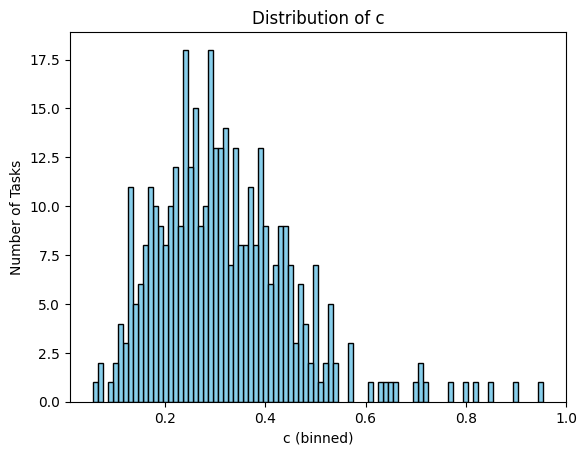

In [9]:
task_c = {}
for task in df['task_id'].unique():
    if not (0 <= task_params_dict[task]["c"] <= 1):
        continue
    acc = task_params_dict[task]["c"]
    task_c[np.round(acc, 2)] = task_c.get(np.round(acc, 2), 0) + 1

plt.bar(task_c.keys(), task_c.values(), width=0.01, color='skyblue', edgecolor='black')
plt.xlabel('c (binned)')
plt.ylabel('Number of Tasks')
plt.title('Distribution of c')

# find 33%, 66% quantiles of c
c_values = sorted([task_params_dict[task]["c"] for task in df['task_id'].unique() if 0 <= task_params_dict[task]["c"] <= 1])
q33 = np.percentile(c_values, 100/3)
q66 = np.percentile(c_values, 200/3)
print(f"33% quantile of c: {q33:.3f}")
print(f"66% quantile of c: {q66:.3f}")

136 tasks with c in (0, 0.25]
120 tasks with c in (0.25, 0.35]
143 tasks with c in (0.35, 1]
136 tasks with c in (0, 0.25]
120 tasks with c in (0.25, 0.35]
143 tasks with c in (0.35, 1]


C:\Users\marin\AppData\Local\Temp\ipykernel_16584\789952989.py:27: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter([d["initial_accuracy"] for d in data.values()],


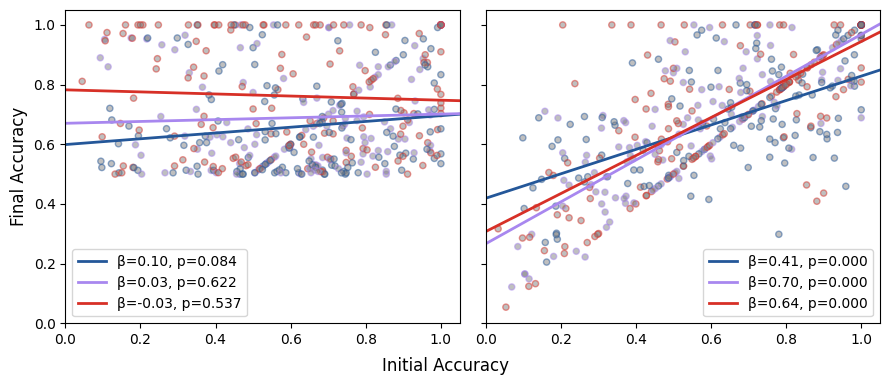

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4), sharex=True, sharey=True)

# remove ticks for ax2
# ax2.tick_params(labelleft=False)
# cax = fig.add_subplot(gs[0, 2])

# bounds = [0, q33, q66, 1]
bounds = [0, 0.25, 0.35, 1]
# bounds = [0, 0.2, 0.3, 1]
stables = initial_final_accuracy_scatter_plot(condition=0, ax=ax[0], plot_colormap=False, bounds=bounds, size=20)
_ = initial_final_accuracy_scatter_plot(condition=1, ax=ax[1], plot_colormap=False, bounds=bounds, size=20)

ax[0].set_xlabel("")          # optional
ax[1].set_xlabel("")          # optional
ax[1].set_ylabel("")          # optional

fig.supxlabel("Initial Accuracy", y=0.05, fontsize=12)
# fig.supylabel("Final Accuracy")

plt.tight_layout()
plt.savefig('plots/WOC/initial_final_accuracy.png', dpi=300)
plt.show()

## Skewness

In [11]:
def skewness_plot_condition(ax=None, 
                            color1='black', color2='navy', color_diff='darkred',
                            label1='Control median', label2='Control mean', label_diff=None,
                            func_y1=lambda params: params['scores'][0],
                            func_y2=lambda params: params['scores_avg'][0],
                            xlabel=None, ylabel=None, ylabel_diff=None,
                            base=dict()):
    if ax is None:
        f, ax = plt.subplots(2, 1, figsize=(4, 6), sharex=True)

    my_base = dict(func_x=lambda task: abs(task_params_dict[task]['skewness']),
                    show_means=False, 
                    annotate_domain_means=False, 
                    s_task=8, alpha_task=0.4,
                    alpha_grid=0,
                    fit_on="all"
                    )
    my_base.update(base)

    all_tasks_regression(**my_base,
                       func_y=func_y1,
                       ax=ax[0], label=label1, color=color1, fit_label=0,
                       xlabel=None, ylabel=None)

    all_tasks_regression(**my_base,
                       func_y=func_y2,
                        ax=ax[0] if len(ax) == 2 else ax[1], label=label2, color=color2, fit_label=0,
                        xlabel=None, ylabel=ylabel)
    
    all_tasks_regression(**my_base,
                       func_y=lambda x: func_y2(x) - func_y1(x),
                        ax=ax[1] if len(ax) == 2 else ax[2], label=label_diff, color=color_diff, show_zero_line=1,
                        xlabel=xlabel, ylabel=ylabel_diff)



c:\Users\marin\Documents\SDU\WoC_revisited\src\dataset_functions.py:728: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


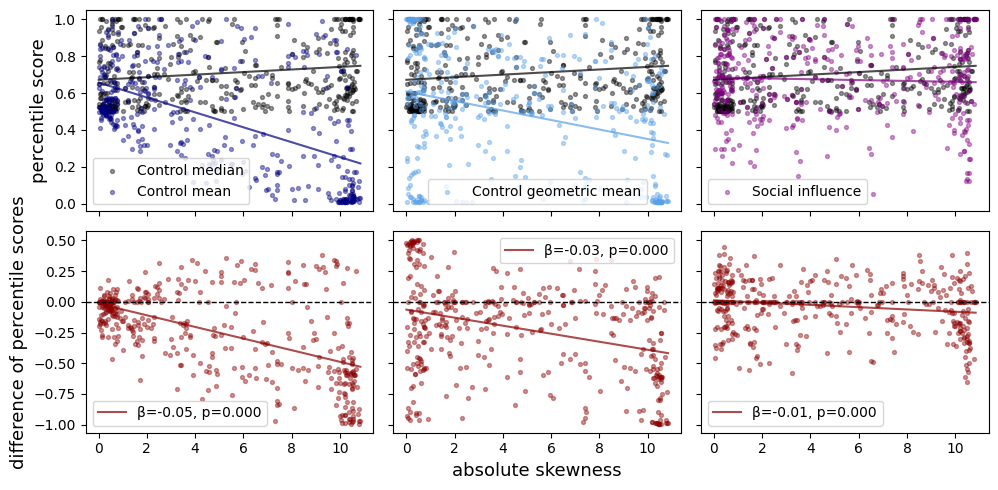

In [12]:
f, ax = plt.subplots(2, 3, figsize=(10, 5), sharex=True, sharey='row')
size = 8
fontsize=13
skewness_plot_condition(ax=ax[:,0], color1='black', color2='navy', color_diff='darkred',
                        ylabel='percentile score', base=dict(ylabel_fontsize=fontsize), ylabel_diff="difference of percentile scores")

skewness_plot_condition(ax=ax[:,1], color1='black', color2='#58A0E8', color_diff='darkred',
                        func_y2=lambda params: params['scores_gmean'][0],
                        label1=None,
                        label2='Control geometric mean', xlabel="absolute skewness", base=dict(xlabel_fontsize=fontsize))

skewness_plot_condition(ax=ax[:,2], color1='black', color2='purple', color_diff='darkred',
                        label1=None,
                        func_y2=lambda params: params['scores'][1],
                        label2='Social influence')
plt.tight_layout()    
plt.savefig("plots/WOC/skewness_vs_scores_no_color.png", dpi=300)
plt.show()


## Condition optimality boxplot

In [13]:
def condition_differences_full(func1=lambda d: [task_params_dict[task_id]["scores"][0] for task_id in df[df['domain_name'] == d]['task_id'].unique()],
                               func2=lambda d: [task_params_dict[task_id]["scores_avg"][0] for task_id in df[df['domain_name'] == d]['task_id'].unique()], 
                               color1="black", color2="navy", diff_color="darkred",
                               label1="Control median", label2="Control mean",
                               ylabel1="percentile score", ylabel2="difference in percentile score",
                               saveto=None):
    domain_names = domains_ordered_by_c
    f, ax = plt.subplots(2, 1, figsize=(9,6), sharex=True)
    x = [3*i for i in range(len(domain_names))]

    myboxplot(x=x, vals=domain_names,
            func=func1,
            xlabels=None, ax=ax[0], box_color=color1, dots_colors=color1, label=label1)
    myboxplot(x=np.array(x) + 0.8, vals=domain_names,
            func=func2,
            xlabels=None, ax=ax[0], box_color=color2, dots_colors=color2, ylabel=ylabel1, label=label2)

    myboxplot(x=np.array(x) + 0.4, vals=domain_names,
            func=lambda d: np.array(func2(d)) - np.array(func1(d)),
            xlabels=[d.replace("_", " ") for d in domain_names], ax=ax[1], box_color=diff_color, dots_colors=diff_color, show_zero_line=True, ylabel=ylabel2,
            label="Difference")

    plt.tight_layout()
    if saveto is not None:
        plt.savefig(saveto, dpi=300)
    plt.show()

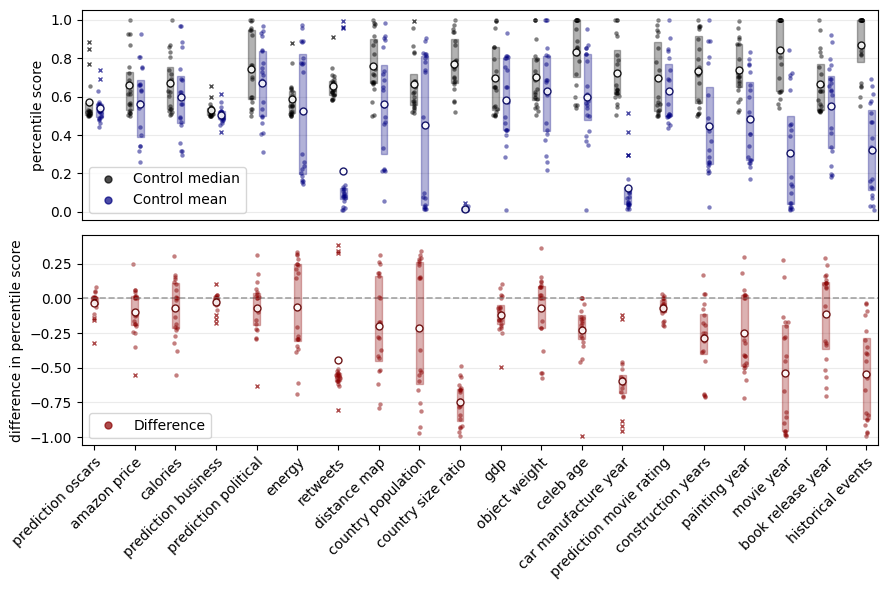

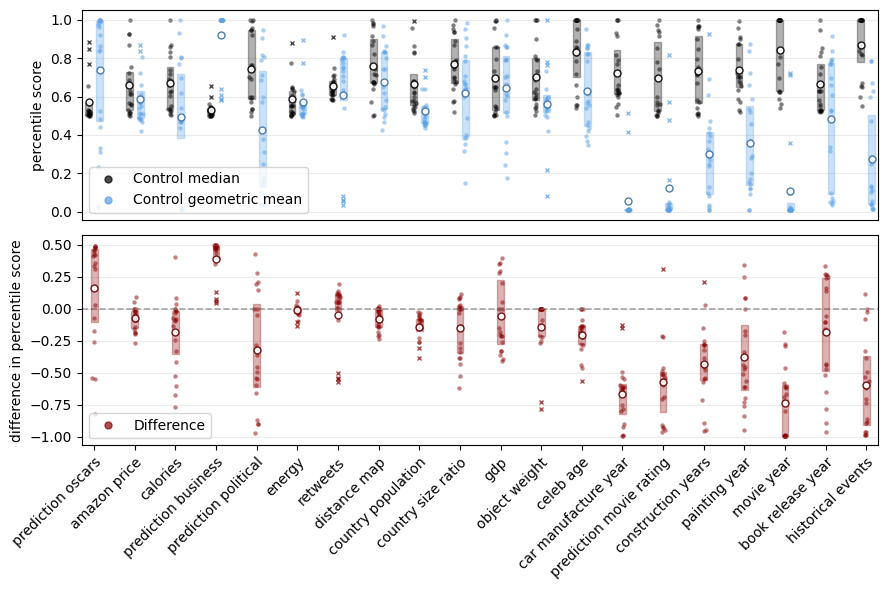

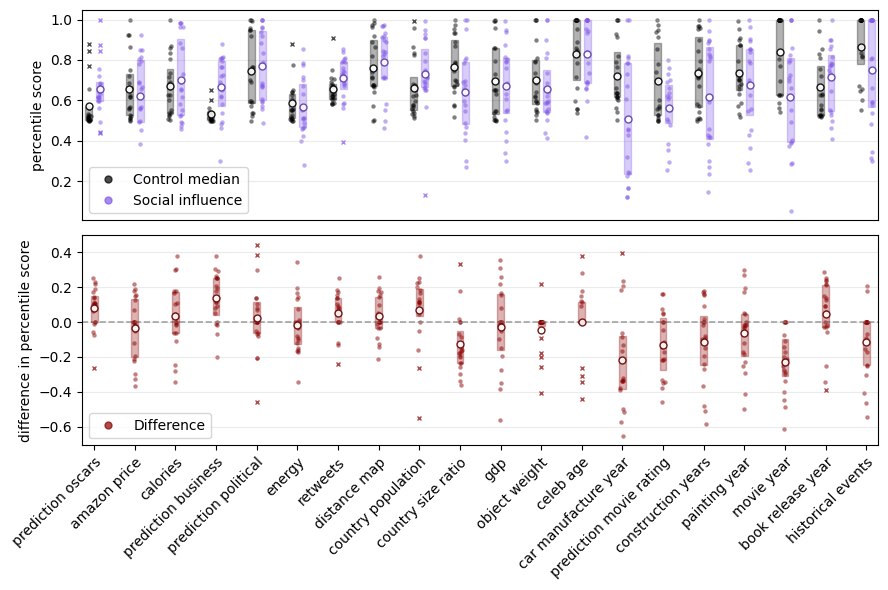

In [14]:
condition_differences_full(saveto="plots/WOC/control_median_vs_mean.png")
condition_differences_full(func2=lambda d: [task_params_dict[task_id]["scores_gmean"][0] for task_id in df[df['domain_name'] == d]['task_id'].unique()],
                          color2="#58A0E8", label2="Control geometric mean",
                          saveto="plots/WOC/control_median_vs_gmean.png")
condition_differences_full(func2=lambda d: [task_params_dict[task_id]["scores"][1] for task_id in df[df['domain_name'] == d]['task_id'].unique()],
                            color2="#8158E8", label2="Social influence",
                            saveto="plots/WOC/control_median_vs_consensus.png")

# Task and domain plots

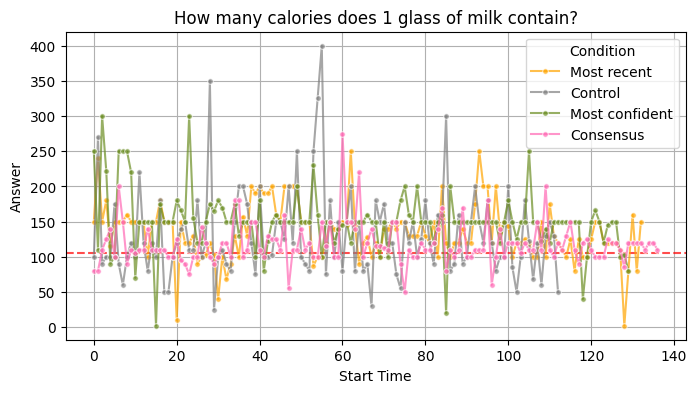

In [15]:
plot_answers_over_time(task_id=1901, ans=True, avg=False, median=False)

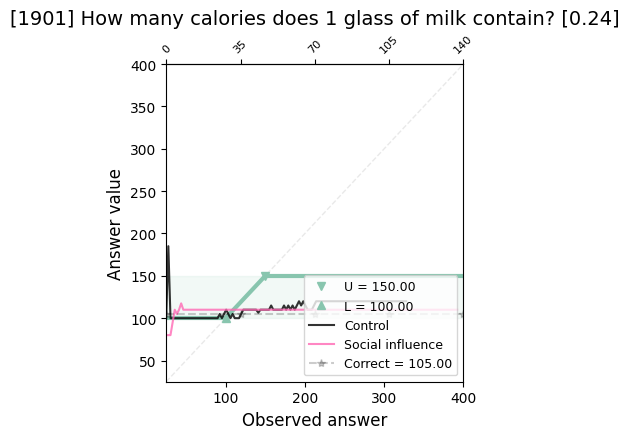

In [16]:
plot_sic_with_traj(1901)

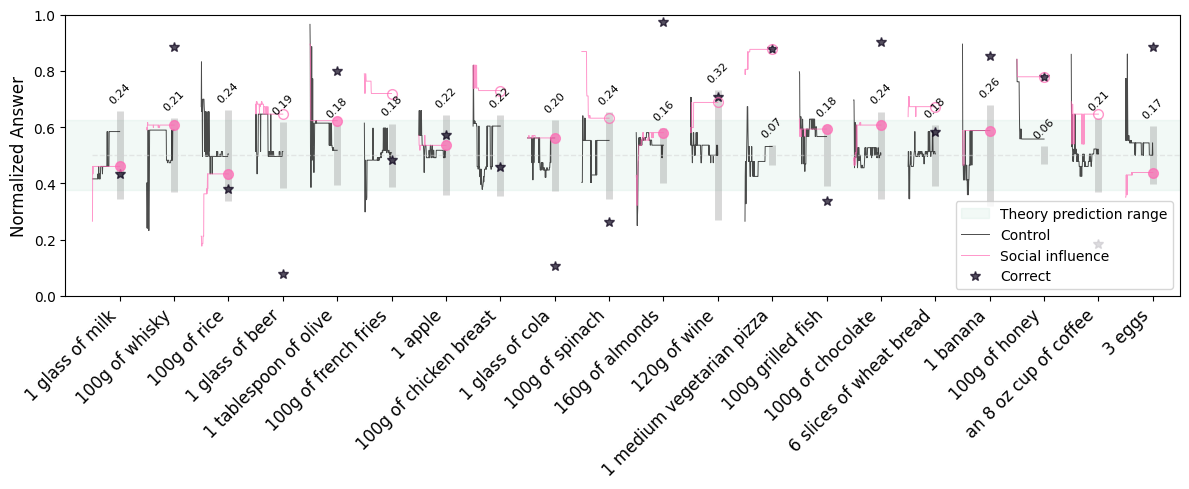

In [17]:
multi_task_plot_norm_horizontal('calories', plot=True)

# Lambda fitting

In [18]:
lambda_fitting_dict = build_lambda_fitting_dict(load=True)
rows = []

for domain, dicts in lambda_fitting_dict.items():
    domain_rows = []
    for key, values in dicts.items():
        if type(key) == int:
            domain_rows.append(["", key] + list(values.values()))
        else:
            method_idx = list(methods.keys()).index(key)
            vals = [""]*len(methods)
            vals[method_idx] = values
            domain_rows.append([domain, ""] + vals)
            
    rows.extend(domain_rows)

# print to a file
# with open('data/lambda_fitting.txt', 'w') as f:
#     f.write(tabulate(rows, headers=["Domain", "Task"] + [f"$\\lambda$ {method.upper()}" for method in methods.keys()], tablefmt="github"))

Loaded precomputed lambda_fitting_dict from disk.


In [20]:
def bootstrapping(task_id, domain=None, T=100, n_samples=100, method='wasserstein'):
    p = 0
    domain_name = task_params_dict[task_id]['domain']
    ctrl_lambda = compute_ctrl_lambda(task_id, lambda_fitting_dict[get(domain, domain_name)][task_id]['wasserstein'])
    n_samples = len(ctrl_lambda)
    # ctrl = np.random.choice(get_answers(task_id), size=n_samples, replace=True)
    for _ in range(T):
        sample = np.random.choice(get_answers(task_id), size=n_samples, replace=True)
        
        # d_lambda = wasserstein_distance(sample, ctrl_lambda)
        d_lambda = wasserstein_distance(ctrl_lambda, get_answers(task_id))
        if method == 'wasserstein':
            d_control = wasserstein_distance(sample, get_answers(task_id))
        else:
            d_control = wasserstein_distance(sample, ctrl)
            
        p += (d_lambda < d_control)
    
    return p / T


plot_results = []
plot_ranges = []
labels = []

T = 1000
N = 100
domains_ordered_by_c = sorted(c_per_domain.keys(), key=lambda x: c_per_domain[x])

for method in ['wasserstein']:
    results = {}
    full_results = {}
    ranges = {}
    for dom in domains_ordered_by_c:
        try:
            full_results[dom] = load_from_file(f'data/bootstrap_pvalues_per_domain_{method}.json').get(dom, {})
            print(f"Loaded precomputed results for domain: {dom} with method: {method}")
        except FileNotFoundError:
            print(f"Computing domain: {dom} with method: {method}")
            full_results[dom] = domain_func(dom, bootstrapping, T=T, n_samples=N, method=method)
        res = list(full_results[dom].values())
        results[dom] = np.mean(res)
        ranges[dom] = (results[dom] - min(res), max(res) - results[dom])

    plot_results.append(results)
    labels.append(f'{method.upper()} {np.mean(list(results.values())):.3f}')
    plot_ranges.append(ranges)
    save_to_json(full_results, f'data/bootstrap_pvalues_per_domain_{method}.json')

Loaded precomputed results for domain: prediction_oscars with method: wasserstein
Loaded precomputed results for domain: amazon_price with method: wasserstein
Loaded precomputed results for domain: calories with method: wasserstein
Loaded precomputed results for domain: prediction_business with method: wasserstein
Loaded precomputed results for domain: prediction_political with method: wasserstein
Loaded precomputed results for domain: energy with method: wasserstein
Loaded precomputed results for domain: retweets with method: wasserstein
Loaded precomputed results for domain: distance_map with method: wasserstein
Loaded precomputed results for domain: country_population with method: wasserstein
Loaded precomputed results for domain: country_size_ratio with method: wasserstein
Loaded precomputed results for domain: gdp with method: wasserstein
Loaded precomputed results for domain: object_weight with method: wasserstein
Loaded precomputed results for domain: celeb_age with method: wass

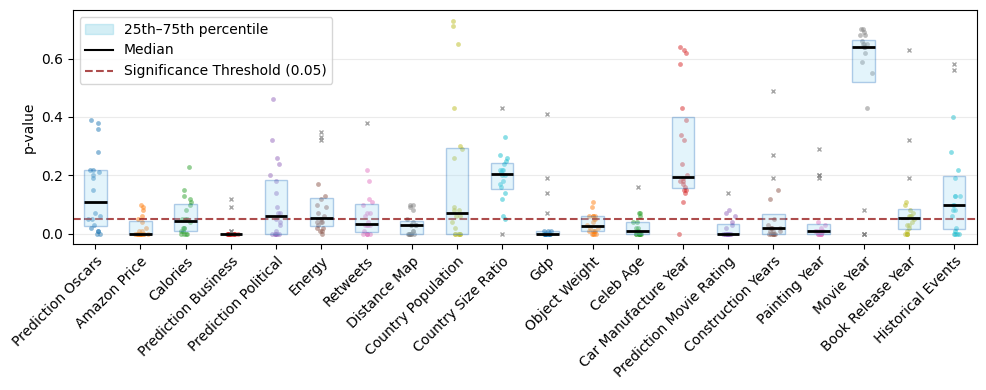

In [21]:
def plot_domain_boxplot(
    full_results_by_domain,
    *,
    title="Bootstrap p-values per Domain",
    ylabel="p-value",
    logy=False,
    showmeans=True,
    path=None,
    ax=None,
):
    """
    full_results_by_domain: dict like {domain: {task_id: p_value, ...}, ...}
    """
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10,4))
    else:
        fig = ax.figure

    # order domains
    domains = list(ordered_domains.keys())

    # gather data
    data = []
    labels = []
    for d in domains:
        vals = list(full_results_by_domain[d].values())
        vals = [v for v in vals if v is not None and np.isfinite(v)]
        if len(vals) == 0:
            continue
        data.append(vals)
        labels.append(d.replace("_", " ").title())

    
    ax.hlines(0.05, xmin=0.5, xmax=len(data)+0.5, colors='darkred', linestyles="dashed", 
              label="Significance Threshold (0.05)", alpha=0.7)


    # boxplot 
    # dont show whiskers, we will plot them manually
    bp = ax.boxplot(
    data,
    tick_labels=labels,
    patch_artist=True,
    boxprops=dict(facecolor="#A4DBF4C1", edgecolor="#0E5FB5B4", alpha=0.3),
    medianprops=dict(color="black", linewidth=2),
    whiskerprops=dict(color="gray", linewidth=1.5),
    capprops=dict(color="gray", linewidth=1.5),
    flierprops=dict(marker="x", markerfacecolor="gray", markeredgecolor="gray", markersize=3, alpha=0.7),
    meanprops=dict(marker="o", markerfacecolor="white", markeredgecolor="black"),
    showmeans=False,
    )

    for w in bp["whiskers"]:
        w.set_visible(False)
    for c in bp["caps"]:
        c.set_visible(False)

    # overlay all points except fliers
    for i, vals in enumerate(data, start=1):          # box positions are 1..N
        # x = np.random.normal(i, 0.06, size=len(vals)) # jitter around the box center
        # ax.scatter(x, vals, s=12, alpha=0.5, linewidths=0)
        keep, out, lo, hi = non_fliers(vals, whis=1.5)
        x = np.random.normal(i, 0.06, size=len(keep))  # jitter
        ax.scatter(x, keep, s=12, alpha=0.5, linewidths=0)

    # # (optional) keep points on top
    # for k in ["boxes","medians","whiskers","caps","means"]:
    #     for artist in bp[k]:
    #         artist.set_zorder(2)

    if logy:
        # p-values in (0,1]; log scale can be harsh if zeros exist
        ax.set_yscale("log")
        ax.set_ylim(bottom=max(1e-6, min(min(d) for d in data if len(d) > 0) * 0.8))

    legend_handles = [
    Patch(color="#6FC9E0", alpha=0.3, label="25th–75th percentile"),
    plt.Line2D([0], [0], color="black", linewidth=1.5, label="Median"),
    # Line2D([0], [0], color="gray", linewidth=1.5, label="Whiskers = up to 1.5xBox"),
    # Line2D([0], [0], marker="o", markerfacecolor="white", markeredgecolor="black", linestyle="None", markersize=5, label="Mean"),
    # Line2D([0], [0], marker=".", color="gray", linestyle="None", markersize=6, alpha=0.6,
    #        label="Fliers = outliers beyond whiskers"),
    plt.Line2D([0], [0], color="darkred", linestyle="dashed", label="Significance Threshold (0.05)", alpha=0.7),
    ]

    ax.set_title(title)
    ax.set_ylabel(ylabel)
    # ax.tick_params(axis="x", rotation=45, labelsize=10)
    ax.tick_params(axis="x", labelsize=10)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    ax.grid(True, axis="y", alpha=0.25)
    ax.legend(handles=legend_handles, loc="upper left", frameon=True)
    fig.tight_layout()

    if path is not None:
        fig.savefig(path, dpi=300, bbox_inches="tight")

    return ax


# ---- use it with your computed results ----
# after your loop, you already have full_results[dom] = {task_id: p_value, ...}

plot_domain_boxplot(
    full_results,
    title=None, #f"Bootstrap p-values per Domain (Wasserstein)",
    logy=0,                                # optional; set False if you prefer linear
    path="plots/bootstrap_pvalues_boxplot.png"
)

plt.show()


# Theory plots

In [ ]:
def influence_curve_values(L, U, mu_lambda=0.0, xs=None):
    """
    Return xs and the corresponding influence-curve values for the simple median model,
    with optional alpha ∈ [0,1].
    """
    if xs is None:
        xs = np.linspace(0, 1, 200)

    ys = np.empty_like(xs)
    mask_lo = xs < L
    mask_mid = (xs >= L) & (xs <= U)
    mask_hi = xs > U

    ys[mask_lo]  = mu_lambda*xs[mask_lo]  + (1-mu_lambda)*L
    ys[mask_mid] = xs[mask_mid]
    ys[mask_hi]  = mu_lambda*xs[mask_hi]  + (1-mu_lambda)*U
    return xs, ys

def plot_influence_curve(L, U, mu_lambda=0.0, ax=None, label=None, 
                         color='black', alpha=0.8, show_identity=1, 
                         flag=1, color_fill='lightgray',
                         ls='-', xs=None):
    """
    Plot the influence curve of the simple median model.
    - alpha=0: pure clamp to [L,U]
    - alpha!=0: sloped outside [L,U]
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(6,4))

    xs, ys = influence_curve_values(L, U, mu_lambda, xs=xs)
    if show_identity > 0:
        ax.plot(xs, xs, linestyle='--', alpha=0.4, color='lightgray', label='y=x' if show_identity == 1 else None)

    # lbl = label if label is not None else (f'Influence (α={mu_lambda:.2f})')
    lbl = label
    ax.plot(xs, ys, color=color, label=lbl, 
            linewidth=2, alpha=alpha, linestyle=ls)
    
    # Shade the equilibria region
    if flag:
        mask = (xs >= L) & (xs <= U)
        ax.fill_between(xs[mask], 0, xs[mask], 
                        # color="#EFF0C0", alpha=0.2)
                        color=color_fill, alpha=0.15)

    ax.set_xlim(xs.min(), xs.max()) 
    ax.set_ylim(xs.min(), xs.max()) 
    # if flag:
    #     ax.set_aspect('equal', adjustable='box')
    
    ax.set_xlabel('Observed median')
    ax.set_ylabel('Median response')
    # de-duplicate legend items if needed
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc='best')
    return ax


## Trajectories

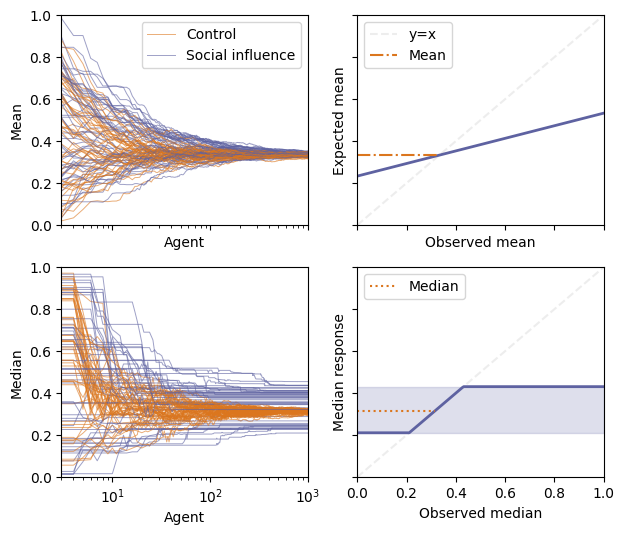

In [7]:
def trajectories_plot(c, setup, N=1000, num_sims=50, load=1, 
                      alpha=0.6, linewidth=0.7,
                      saveto=None):
    found = False
    fig, ax = plt.subplots(2, 2, figsize=(7, 6), sharex='col', sharey=True)

    colors = ["#DB761E", '#5E62A1', '#B74854', '#48B7AB']
    
    # plot theory
    plot_influence_curve(L=setup['mean'], U=setup['mean'], ax=ax[0,1], 
                         color=colors[1], mu_lambda=c, show_identity=1, alpha=1)
    ax[0,1].set_xlabel("Observed mean")
    ax[0,1].set_ylabel("Expected mean")
    ax[0,1].hlines(setup['mean'], 0, setup['mean'], color=colors[0], linestyle='-.', label=f'Mean')

    plot_influence_curve(L=setup['L'], U=setup['U'], ax=ax[1,1], 
                         color=colors[1], show_identity=2, flag=0, alpha=1)
    ax[1,1].hlines(setup['median'], 0, setup['median'], color=colors[0], linestyle=':', label=f'Median')

    ax[1,1].fill_between([0, 1], setup['L'], setup['U'], color=colors[1], alpha=0.2)
    
    # plot sims
    if load:
        try:
            sim_data = load_from_file("data/simulations_theory.json")
            found = True
        except:
            pass
    if not found:
        sims_no_c = [{} for _ in range(num_sims)]
        sims_c = [{} for _ in range(num_sims)]
        for sim in range(num_sims):
            medians_no_c = simulation([setup['user_func_no_c']() for _ in range(N-3)], init=np.random.rand(), initial_users=3)["medians"]
            avgs_no_c = simulation_avg([setup['user_func_no_c']() for _ in range(N-3)], init=np.random.rand(), initial_users=3)["avgs"]

            medians_c = simulation([setup['user_func_c']() for _ in range(N-3)], init=np.random.rand(), initial_users=3)["medians"]
            avgs_c = simulation_avg([setup['user_func_c']() for _ in range(N-3)], init=np.random.rand(), initial_users=3)["avgs"]

            sims_no_c[sim] = {"medians": medians_no_c, "avgs": avgs_no_c}
            sims_c[sim] = {"medians": medians_c, "avgs": avgs_c}

        sim_data = {'no_c': {'medians': [list(x['medians']) for x in sims_no_c], 'avgs': [list(x['avgs']) for x in sims_no_c]}, 
                    'c':    {'medians': [list(x['medians']) for x in sims_c], 'avgs': [list(x['avgs']) for x in sims_c]}}
        save_to_json(sim_data, "simulations_theory.json")

    for i in range(len(sim_data['c']['avgs'])):
        # T = range(1, len(sim_data['c']['avgs'][i]) + 1)
        ax[0,0].plot(sim_data['no_c']['avgs'][i], color=colors[0], alpha=alpha, linewidth=linewidth, label='Control' if i==0 else "")
        ax[0,0].plot(sim_data['c']['avgs'][i], color=colors[1], alpha=alpha, linewidth=linewidth, label='Social influence' if i==0 else "")

        ax[1,0].plot(sim_data['no_c']['medians'][i], color=colors[0], alpha=alpha, linewidth=linewidth)
        ax[1,0].plot(sim_data['c']['medians'][i], color=colors[1], alpha=alpha, linewidth=linewidth)

    for i, j in [(0,1), (1,1)]:
        ax[i,j].set_xlim(0, 1)
        ax[i,j].set_ylim(0, 1)
        ax[i,j].legend(loc="best", fontsize=10)
    
    for i, j in [(0,0), (1,0)]:
        ax[i,0].set_ylabel("Mean" if i==0 else "Median")
        ax[i,0].set_xlabel("Agent")
        ax[i,0].set_xscale("log")
        ax[i,0].set_xlim(3, N+1)
    
    ax[0,0].legend(loc="best", fontsize=10)
    
    plt.savefig(f'plots/theory/{get(saveto, f'trajectories_plot_c{c:.2f}')}.png', dpi=300)
    plt.show()
    plt.close()


c = 0.3
k = min(1, c/(1-c+1e-5))
a = 2
b = 4
setup = {
    'L': beta.ppf(1/2 - k/2, a=a, b=b),
    'U': beta.ppf(1/2 + k/2, a=a, b=b),
    'mean': a / (a + b),
    'median': beta.ppf(0.5, a=a, b=b),
    'user_func_no_c': lambda:  BetaUser(a=a, b=b, lmbda=0.0), # MixingUser(c=0, lmbda=0), #
    'user_func_c': lambda: BetaUser(a=a, b=b, lmbda=c) # MixingUser(c=c, lmbda=0)
}
trajectories_plot(c=0.3, setup=setup, N=1000, num_sims=50, load=1)


## Model SIC

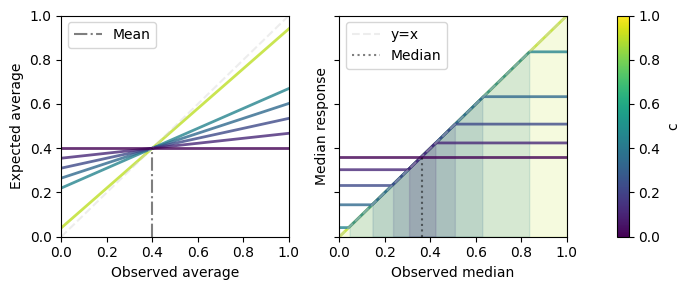

In [8]:
# 1x2 plots with different mu_c

f, (ax1, ax2, cax) = plt.subplots(1, 3, figsize=(7, 3), gridspec_kw={'width_ratios': [1, 1, 0.05],}, sharey=True)
ax = [ax2, ax1]


a = 0.8
b = 1.2
# get 0.5 percentile of Beta(a, b)

median = beta.ppf(0.5, a, b)
average = a / (a + b)

mu_cs = np.linspace(0, 0.45, 5)
mu_cs = np.append(mu_cs, 0.9)  # ensure mu_c=0 is included
norm_ = mcolors.Normalize(vmin=0, vmax=1)

for i, mu_c in enumerate(mu_cs[::-1]):
    color = cm.viridis(norm_(mu_c))

    k = min(1, mu_c/(1-mu_c + 1e-5))

    L = beta.ppf(1/2 - k/2, a, b)
    U = beta.ppf(1/2 + k/2, a, b)

    plot_influence_curve(L=L, U=U, ax=ax[0], 
                         color=color, alpha=0.8, show_identity=(mu_c==0), color_fill=color)
    
    # ax[0].axvspan(setup['L'], setup['U'], ymax=setup['L'], color=color, alpha=0.15, zorder=-1)
    
    plot_influence_curve(L=average, U=average, ax=ax[1], mu_lambda=mu_c, 
                         color=color, alpha=0.8, show_identity=2 if mu_c==0 else 0)

# Add vertical lines for median and average
ax[0].axvline(median, ymax=median, color='black', linestyle=':', label='Median', alpha=0.5)
ax[1].axvline(average, ymax=average, color='black', linestyle='-.', label='Mean', alpha=0.5)

ax[1].set_xlabel('Observed average')
ax[1].set_ylabel('Expected average')

ax[0].legend()
ax[1].legend()

# add colorbar for c
sm = cm.ScalarMappable(cmap=cm.viridis)
sm.set_array([])
# make colorbar smaller and aligned with the two plots
cbar = plt.colorbar(sm, cax=cax, orientation='vertical', label=r'c', shrink=0.75)

plt.tight_layout()
plt.savefig(f'plots/theory/influence_curve_varying_c.png', dpi=300)
plt.show()
plt.close()

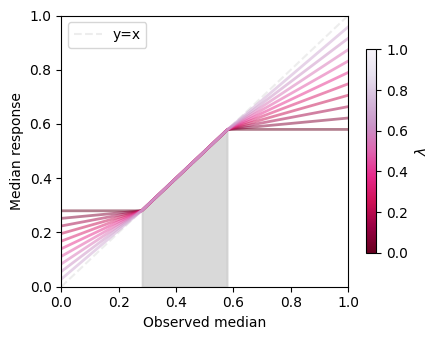

In [9]:
fig, ax = plt.subplots(figsize=(4.5,3.5))

seed = 1
mu_r = 0.4
sigma_r = 0.2
User.a = 2
User.b = 3
beta_users = 1
distr_name = f'Beta({User.a}, {User.b})' if beta_users else f'Normal({mu_r}, {sigma_r})'

mu_lambda = 0.15
mu_c = 0.3

lambdas = np.linspace(0, 0.9, 10)

# setup = setup_simulation(100, 500, mu_r, sigma_r, mu_c, seed, beta_users)
L = 0.28
U = 0.58
median = 0.4

norm_ = mcolors.Normalize(vmin=0, vmax=1.3)

# plot multiple values for mu_lambda
for m_l in lambdas:
    plot_influence_curve(L=L, U=U, ax=ax, mu_lambda=m_l, 
                         color=cm.PuRd_r(norm_(m_l)),
                         alpha=0.5, show_identity=(m_l==0))
    
# add colorbar for alpha
sm = cm.ScalarMappable(cmap=cm.PuRd_r)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', label=r'$\lambda$', shrink=0.75)


handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='best')

# plt.title(fr'{distr_name} - $\mu_c$={mu_c:.2f}')
plt.tight_layout()
plt.savefig(f'plots/theory/influence_curve_varying_lambda_c{mu_c:.2f}.png', dpi=300)
plt.show()
plt.close()

## Last update

In [2]:
def full_distr_of_last_update(
    N=100, eps=1e-6, c=0.2, lamda=0.2, K=100,
    signal='med', color='skyblue',
    xlabel= ' ',
    bars=False, ax=None, title=None,
    len_bins=5, linewidth=1.8, alpha=1.0
):
    """
    Simulate K runs and compute t_conv = last index where |res - final| >= eps, +1.
    Plot KDE of (t_conv / len_bins) so x-axis is in "bins of len_bins iterations".
    Returns raw t_values counts (length N+3).
    """
    signal_params = {
        'avg': {'simulation_func': simulation_avg, 'result_key': "avgs"},
        'med': {'simulation_func': simulation,     'result_key': "medians"},
    }

    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 4))

    t_values = np.zeros(N + 3, dtype=int)

    for rep in range(K):
        users = [MixingUser(c=c, lmbda=lamda) for _ in range(N)]
        result = signal_params[signal]['simulation_func'](users, init=np.random.rand())
        res = np.array(result[signal_params[signal]['result_key']])

        final_val = res[-1]
        diffs = np.abs(res - final_val)
        idx = np.where(diffs >= eps)[0]
        t_conv = (idx[-1] + 1) if len(idx) else 1
        t_values[t_conv] += 1

    # Build sample list of t_conv values, then scale to bins
    samples = np.repeat(np.arange(len(t_values)), t_values)
    if len(samples) == 0:
        return t_values

    samples_binned = samples / len_bins  # plot in units of "bins"
    kde = gaussian_kde(samples_binned)

    x_grid = np.linspace(0, (N + 3) / len_bins, 1000)
    kde_vals = kde(x_grid)

    # Optional bar plot (also in binned units)
    if bars:
        num_bins = int(np.ceil((N + 3) / len_bins))
        summed = [t_values[i:i+len_bins].sum() for i in range(0, len(t_values), len_bins)]
        ax.bar(np.arange(len(summed)), summed, color=color, alpha=0.20)

    # Plot KDE scaled to frequency-like scale
    # Multiply by (K * len_bins) so area roughly matches counts-per-bin visualization.
    ax.plot(x_grid, kde_vals * (len_bins), color=color, linewidth=linewidth, alpha=alpha)
    avg = np.sum(samples) / K

    ax.vlines(avg / len_bins, ymin=0, ymax=kde(avg / len_bins) * (len_bins), linestyle=':', color=color, linewidth=linewidth)

    if title:
        ax.set_title(title)

    ax.set_xlabel(xlabel if xlabel else f"Last update (t), binned by {len_bins}")
    ax.set_ylabel("Frequency (scaled KDE)")
    return t_values

def plot_last_update_grid(
    N=97, K=100, eps_med=0.025, eps_avg=0.025,
    c_list=(0, 0.1, 0.2, 0.3, 0.4, 0.49),
    lamda_list=(0, 0.2, 0.4, 0.6, 0.8),
    len_bins=5,
    cmap_name="viridis"
):
    """
    6x2 panel:
      - rows: c in c_list
      - col0: median simulations (signal='med')
      - col1: avg simulations (signal='avg')
    Each subplot overlays curves for all lamda in lamda_list.
    """
    nrows = len(c_list)
    fig, ax = plt.subplots(nrows, 2, figsize=(7, 1.6 * nrows), sharex=True, sharey="row")

    cmap = plt.get_cmap(cmap_name, len(lamda_list))
    lam_colors = {lam: cmap(i) for i, lam in enumerate(lamda_list)}

    for r, c in enumerate(c_list):
        for col, (signal, eps) in enumerate([("avg", eps_avg), ("med", eps_med)]):
            a = ax[r, col]

            # Overlay lamdas
            for i, lam in enumerate(lamda_list):
                full_distr_of_last_update(
                    N=N, eps=eps, c=c, lamda=lam, K=K,
                    signal=signal, color=lam_colors[lam],
                    xlabel = " " if r < nrows - 1 else f"Timestep of last update",
                    bars=False, ax=a, title=None, len_bins=len_bins,
                    linewidth=2.0, alpha=0.95
                )

            # Titles/labels
            if r == 0:
                a.set_title("Median dynamics" if signal=="med" else "Mean dynamics")
            if col == 0:
                a.set_ylabel(fr"c = {c:.2f}" + "\nFrequency")
            else:
                a.set_ylabel("")  # keep clean, sharey per row

            # Legend only on first row (or last row) to avoid clutter
            if r == nrows - 1 and col == 1:
                handles = [plt.Line2D([0], [0], color=lam_colors[lam], lw=2) for lam in lamda_list]
                labels = [fr"$\lambda$={lam:.1f}" for lam in lamda_list]
                a.legend(handles, labels, loc="upper right", frameon=True, fontsize=9)

    # X ticks in original units
    x_max_bins = (N + 3) / len_bins
    xticks = np.linspace(0, x_max_bins, 6)
    for a in ax[-1, :]:
        a.set_xticks(xticks)
        a.set_xticklabels([f"{int(t * len_bins)}" for t in xticks])

    ax[0][0].set_xlim(0, x_max_bins)

    plt.tight_layout()
    return fig, ax

FileNotFoundError: [Errno 2] No such file or directory: 'plots/theory/full_distr_last_update_grid_4x2.png'

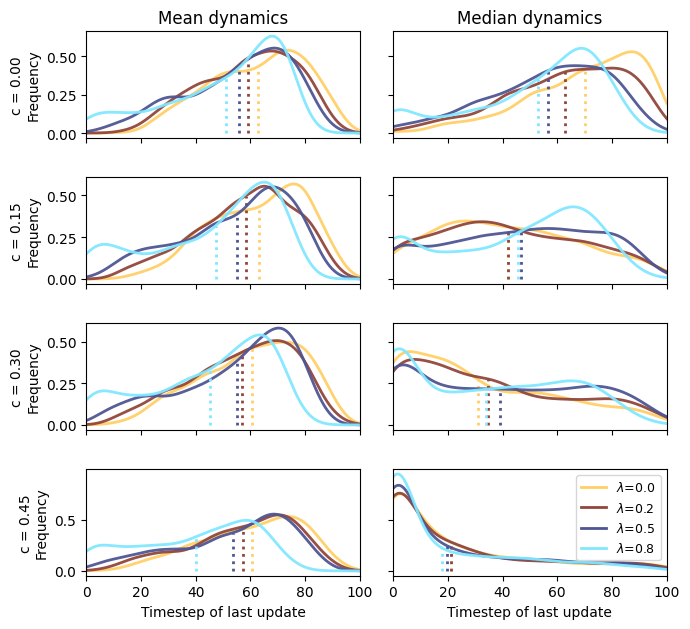

In [3]:
MixingUser.mu_r = 0.5
MixingUser.sigma_r = 0.2

fig, ax = plot_last_update_grid(
    N=97, K=1000,
    eps_med=0.015, eps_avg=0.015,
    # c_list=[0, 0.1, 0.2, 0.3, 0.4, 0.49],
    # c_list=[0, 0.125, 0.25, 0.375, 0.5],
    c_list=[0, 0.15, 0.3, 0.45],
    lamda_list=[0, 0.2, 0.5, 0.8],
    len_bins=5,
    cmap_name="managua"
)

plt.savefig("plots/theory/full_distr_last_update_grid_4x2.png", dpi=300)
plt.show()